In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from corner import corner
from functools import partial

import dynesty
import dynesty.plotting as dyplot

from thesis.io import gyre, fgong
from thesis.physics import sound_speed, acoustic_depth
from thesis.calculus import differentiate

import jax
import jax.numpy as jnp
from jax import random, tree_util
from jax.scipy.stats import norm, uniform
jax.config.update("jax_enable_x64", True)

import tinygp
from tinygp import kernels, GaussianProcess

In [3]:
root_path = os.path.expanduser("~/OneDrive/Data/MESA/solar_models/y0.28/")
profile_name = "profile"

filename = os.path.join(root_path, ".".join([profile_name, "data", "FGONG"]))
gong = fgong.load_fgong(filename)
gong

<xarray.Dataset>
Dimensions:       (x: 1046)
Coordinates:
  * x             (x) float64 0.0 0.0009072 0.001143 ... 1.001 1.001 1.001
Data variables: (12/36)
    r             (x) float64 0.0 6.399e+07 8.063e+07 ... 7.062e+10 7.062e+10
    ln_q          (x) float64 -708.4 -16.36 -15.67 -14.98 ... 0.0 0.0 0.0 0.0
    T             (x) float64 1.549e+07 1.549e+07 ... 4.78e+03 4.78e+03
    P             (x) float64 2.22e+17 2.22e+17 2.22e+17 ... 95.79 93.64 91.76
    rho           (x) float64 141.5 141.5 141.5 ... 2.945e-10 2.885e-10
    X             (x) float64 0.3762 0.3762 0.3762 ... 0.7304 0.7304 0.7304
    ...            ...
    X_Li7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Be7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_N15         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O17         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O18         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Ne20        (x) float64 0.002143 0.002143 0.002143 ... 0.001851 0.001851
Attributes: (12/15)
    M:               1.9884098706980504e+33
    R:               70538857450.55437
    L:               3.695049456876695e+33
    initial_Z:       0.02
    initial_X:       0.7
    alpha_MLT:       1.9
    ...              ...
    lambda_surf:     0.0
    d2lnPc_dlnr2:    -125.502754776413
    d2lnrhoc_dlnr2:  -163.89137578671765
    star_age:        4073344465.7814794
    Teff:            5681.793600417881
    G:               6.6743e-08

In [4]:
summary_filename = os.path.join(root_path, profile_name, "summary.h5")
detail_filenames = glob(os.path.join(root_path, profile_name, "detail*"))

pulse = gyre.load_output(summary_filename, detail_filenames)
pulse

<xarray.Dataset>
Dimensions:  (n_pg: 36, l: 3, x: 1046)
Coordinates:
  * n_pg     (n_pg) int64 1 2 3 4 5 6 7 8 9 10 ... 27 28 29 30 31 32 33 34 35 36
  * l        (l) int64 0 1 2
  * x        (x) float64 0.0 0.0009072 0.001143 0.00144 ... 1.001 1.001 1.001
Data variables:
    E_norm   (n_pg, l) float64 0.005267 nan 0.002007 ... 8.809e-09 nan nan
    freq     (n_pg, l) complex128 (255.42893986791924+0j) ... (nan+nanj)
    omega    (n_pg, l) complex128 (2.6099776215242243+0j) ... (nan+nanj)
    As       (x, n_pg, l) float64 0.0 nan 0.0 0.0 ... 2.331e+03 nan nan
    V_2      (x, n_pg, l) float64 125.5 nan 125.5 125.5 ... 5.896e+03 nan nan
    c_1      (x, n_pg, l) float64 0.009557 nan 0.009557 ... 1.003 nan nan
    xi_h     (x, n_pg, l) complex128 0j (nan+nanj) 0j ... (nan+nanj) (nan+nanj)
    xi_r     (x, n_pg, l) complex128 0j (nan+nanj) 0j ... (nan+nanj) (nan+nanj)
Attributes:
    freq_units:  UHZ
    label:

In [5]:
data = gong.merge(pulse, combine_attrs="drop_conflicts")
data

<xarray.Dataset>
Dimensions:       (x: 1046, n_pg: 36, l: 3)
Coordinates:
  * x             (x) float64 0.0 0.0009072 0.001143 ... 1.001 1.001 1.001
  * n_pg          (n_pg) int64 1 2 3 4 5 6 7 8 9 ... 28 29 30 31 32 33 34 35 36
  * l             (l) int64 0 1 2
Data variables: (12/44)
    r             (x) float64 0.0 6.399e+07 8.063e+07 ... 7.062e+10 7.062e+10
    ln_q          (x) float64 -708.4 -16.36 -15.67 -14.98 ... 0.0 0.0 0.0 0.0
    T             (x) float64 1.549e+07 1.549e+07 ... 4.78e+03 4.78e+03
    P             (x) float64 2.22e+17 2.22e+17 2.22e+17 ... 95.79 93.64 91.76
    rho           (x) float64 141.5 141.5 141.5 ... 2.945e-10 2.885e-10
    X             (x) float64 0.3762 0.3762 0.3762 ... 0.7304 0.7304 0.7304
    ...            ...
    omega         (n_pg, l) complex128 (2.6099776215242243+0j) ... (nan+nanj)
    As            (x, n_pg, l) float64 0.0 nan 0.0 0.0 ... 2.331e+03 nan nan
    V_2           (x, n_pg, l) float64 125.5 nan 125.5 ... 5.896e+03 nan nan
    c_1           (x, n_pg, l) float64 0.009557 nan 0.009557 ... 1.003 nan nan
    xi_h          (x, n_pg, l) complex128 0j (nan+nanj) ... (nan+nanj)
    xi_r          (x, n_pg, l) complex128 0j (nan+nanj) ... (nan+nanj)
Attributes: (12/17)
    M:               1.9884098706980504e+33
    R:               70538857450.55437
    L:               3.695049456876695e+33
    initial_Z:       0.02
    initial_X:       0.7
    alpha_MLT:       1.9
    ...              ...
    d2lnrhoc_dlnr2:  -163.89137578671765
    star_age:        4073344465.7814794
    Teff:            5681.793600417881
    G:               6.6743e-08
    freq_units:      UHZ
    label:

In [6]:
data["cs"] = sound_speed(data.Gamma_1, data.P, data.rho)
data["tau"] = acoustic_depth(data.r, data.cs)
tau0 = data["tau"].max()
nu0 = 5e5 / tau0
print(f"Acoustic radius is {tau0:.2f} s")
print(f"Characteristic frequency is {nu0:.2f} uHz")

Acoustic radius is 3710.25 s
Characteristic frequency is 134.76 uHz


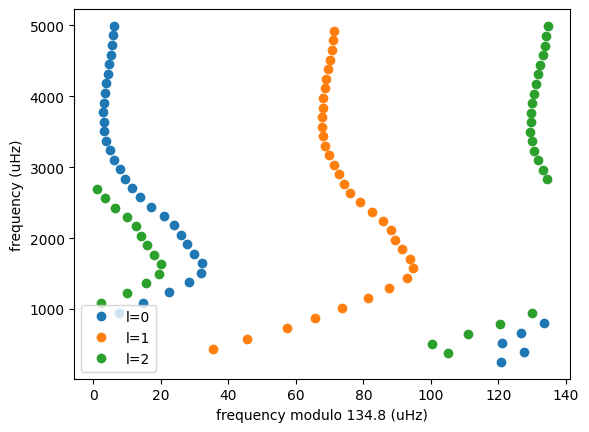

In [7]:
fig = plt.figure()

freq_mod = data.freq.real%nu0
for j in data.l:
    plt.plot(freq_mod.sel(l=j), data.freq.real.sel(l=j), 'o', color=f'C{j:d}', label=f'l={j:d}')
#     plt.plot(freq_mod.sel(l=j)-nu0, ds.freq.real.sel(l=j), 'o', color=f'C{j:d}')

plt.xlabel(f'frequency modulo {nu0:.1f} (uHz)')
plt.ylabel('frequency (uHz)')
plt.legend();

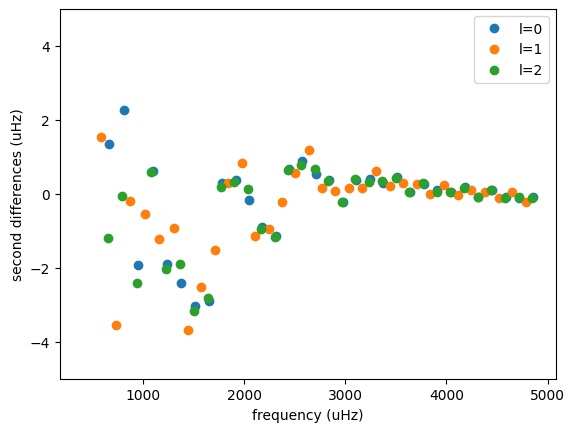

In [8]:
plt.figure()

d2nu = data.freq.real[:-2].values - 2 * data.freq.real[1:-1].values + data.freq.real[2:].values

for j in range(3):
    plt.plot(data.freq.real[1:-1, j], d2nu[:, j], 'o', color=f'C{j:d}', label=f'l={data.l[j]:d}')

plt.xlabel('frequency (uHz)')
plt.ylabel('second differences (uHz)')
plt.ylim(-5, 5)
plt.legend();

In [49]:
class Distribution:
    periodic = False
    reflective = False

    def prior_transform(self, u):
        pass

    def log_probability(self, y):
        pass
    
    def sample(self, key, shape=()):
        pass
    
    @property
    def mean(self):
        pass

    @property
    def variance(self):
        pass


class Normal(Distribution):
    def __init__(self, loc, scale):
        self.loc = loc
        self.scale = scale
    
    def prior_transform(self, u):
        return norm.ppf(u, self.loc, self.scale)

    def log_probability(self, y):
        return norm.logpdf(y, self.loc, self.scale)
    
    def sample(self, key, shape=(), dtype=jnp.float_):
        return random.normal(key, shape=shape, dtype=dtype)

    @property
    def mean(self):
        return self.loc

    @property
    def variance(self):
        return self.scale**2


class Uniform(Distribution):
    def __init__(self, low=0.0, high=1.0):
        self.low = low
        self.high = high
        self.loc = low
        self.scale = high - low

    def prior_transform(self, u):
        return self.loc + self.scale * u
    
    def log_probability(self, y):
        uniform.logpdf(y, self.loc, self.scale)

    def sample(self, key, shape=(), dtype=jnp.float_):
        return random.uniform(key, shape=shape, dtype=dtype, minval=self.low, maxval=self.high)
    
    @property
    def mean(self):
        return (self.low + self.high) / 2.0
    
    @property
    def variance(self):
        return (self.high - self.low)**2 / 12.0


class CircularUniform(Uniform):
    periodic = True
    def __init__(self, low=0.0, high=2*jnp.pi):
        super().__init__(low, high)

    def prior_transform(self, u):
        return super().prior_transform(jnp.mod(u, 1.0))
    
    def log_probability(self, y):
        uniform.logpdf(y, self.loc, self.scale)

    def sample(self, key, shape=(), dtype=jnp.float_):
        return random.uniform(key, shape=shape, dtype=dtype, minval=self.low, maxval=self.high)
    
    @property
    def mean(self):
        return (self.low + self.high) / 2.0
    
    @property
    def variance(self):
        return (self.high - self.low)**2 / 12.0

In [146]:
class Model:
    def __init__(self, n, nu, nu_err=None, prior=None):
        self.n = n
        self.nu = nu
        self.nu_err = nu_err
        
        if prior is None:
            prior = {}
        
        # Get some useful params for prior
        w = None if nu_err is None else 1/nu_err
        popt, pcov = jnp.polyfit(self.n.astype(float), self.nu, 1, w=w, cov=True)
        perr = jnp.sqrt(jnp.diag(pcov))
            
        delta_nu = prior.setdefault(
            "delta_nu", Normal(popt[0], perr[0])
        )
        
        prior.setdefault(
            "epsilon", Normal(popt[1]/delta_nu.mean, perr[1]/delta_nu.mean)
        )

        log_tau_he = prior.setdefault("log_tau_he", Normal(
            jnp.log(0.2/2/delta_nu.mean),  # tau ~ 0.2 tau0
            jnp.sqrt(0.04 + delta_nu.variance/delta_nu.mean**2)  # 0.2
        ))
        
        log_beta_he = prior.setdefault("log_beta_he", Normal(
            2*(log_tau_he.mean + jnp.log(0.1*jnp.pi)) + jnp.log(8.0),  # beta ~ 8 * (np.pi * 0.1 * tau)**2
            jnp.sqrt(0.25 + 4*log_tau_he.variance)  # 0.5
        ))
        # beta = 8 * pi**2 * delta**2
        
        prior.setdefault("log_gamma_he", Normal(
            0.5*(log_beta_he.mean -  jnp.log(jnp.pi)) + jnp.log(0.5*0.1), # gamma ~ 1/2 * 0.1 * sqrt(beta/pi)
            jnp.sqrt(0.64 + 0.25*log_beta_he.variance)  # 0.8
        ))
        # alpha_he = (dgamma / gamma)_min = gamma_he / sqrt(2pi) / delta_he
        # a_he = delta_nu * gamma_he
        
        prior.setdefault("log_alpha_cz", Normal(
            jnp.log(delta_nu.mean*30.0), 
            jnp.sqrt(0.64 + delta_nu.variance/delta_nu.mean**2)  # 0.8
        ))
        
        prior.setdefault("log_tau_cz", Normal(
            jnp.log(0.6/2/delta_nu.mean),  # tau ~ 0.6 tau0
            jnp.sqrt(0.04 + delta_nu.variance/delta_nu.mean**2)  # 0.2
        ))
        
        prior.setdefault("phi_he", CircularUniform())
        prior.setdefault("phi_cz", CircularUniform())
                
        prior.setdefault("log_sigma", Normal(jnp.log(0.01), 2.0))
        # prior.setdefault("log_amp", Normal(jnp.log(delta_nu.mean/2), 2.0))
        # prior.setdefault("log_scale", Normal(jnp.log(5.0), 2.0))

        self.prior = prior
    
    @staticmethod
    def _oscillation(nu, tau, phi):
        return jnp.sin(4 * jnp.pi * tau * nu + phi)
    
    def smooth_component(self, params, n):
        return params["delta_nu"] * (n + params["epsilon"])
    
    def helium_amp(self, params, nu):
        return params["delta_nu"] * jnp.exp(params["log_gamma_he"]) * nu \
            * jnp.exp(- jnp.exp(params["log_beta_he"]) * nu**2)

    def helium_osc(self, params, nu):
        return self._oscillation(nu, jnp.exp(params["log_tau_he"]), params["phi_he"])

    def helium_glitch(self, params, nu):
        return self.helium_amp(params, nu) * self.helium_osc(params, nu)

    def bcz_amp(self, params, nu):
        return params["delta_nu"] * jnp.exp(params["log_alpha_cz"]) / nu**2

    def bcz_osc(self, params, nu):
        return self._oscillation(nu, jnp.exp(params["log_tau_cz"]), params["phi_cz"])

    def bcz_glitch(self, params, nu):
        return self.bcz_amp(params, nu) * self.bcz_osc(params, nu)

    def glitch(self, params, nu):
        return self.helium_glitch(params, nu) + self.bcz_glitch(params, nu)

    def build_gp(self, params):
        # kernel = jnp.exp(params["log_amp"]) * kernels.ExpSquared(jnp.exp(params["log_scale"]))
        kernel = 0.5*params["delta_nu"] * kernels.ExpSquared(5.0)
        
        def mean(n):
            nu_sm = self.smooth_component(params, n)
            dnu = self.glitch(params, nu_sm)
            return nu_sm + dnu
        
        diag = jnp.exp(2*params["log_sigma"])
        if self.nu_err is not None:
            diag += self.nu_err**2
        
        return GaussianProcess(kernel, self.n, mean=mean, diag=diag)

    def predict(self, params, n, **kwargs):
        gp = self.build_gp(params)
        _, cond = gp.condition(self.nu, n, **kwargs)
        return cond.loc, cond.variance

    @partial(jax.jit, static_argnums=0)
    def log_likelihood(self, params):
        gp = self.build_gp(params)
        return gp.log_probability(self.nu)
    
    @partial(jax.jit, static_argnums=0)
    def prior_transform(self, uparams):
        params = {}
        for key, value in self.prior.items():
            params[key] = value.prior_transform(uparams[key])

        return params

    @partial(jax.jit, static_argnums=0)
    def log_prior(self, params):
        log_p = 0.0
        for key, value in self.prior.items():
            log_p += value.log_probability(params[key])
        return log_p

In [147]:
l = 0
n = np.arange(11, 29)
nu = data.freq.real.sel(l=l, n_pg=n).values
delta_nu, alpha = np.polyfit(n, nu, 1)
epsilon = alpha/delta_nu

print(f"{delta_nu=:.2f}")

delta_nu=132.87


<ErrorbarContainer object of 3 artists>

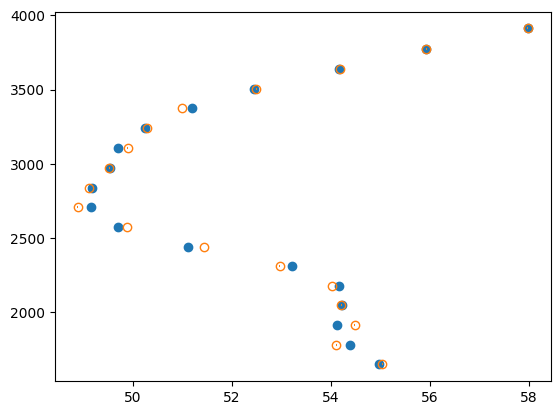

In [148]:
model = Model(n, nu)

init_params = {k: v.mean for k, v in model.prior.items()}

nu_gp, nu_var = model.predict(init_params, n, include_mean=False)
nu_sd = np.sqrt(nu_var)

nu_sm = model.smooth_component(init_params, n)
dnu_init = model.glitch(init_params, nu_sm)

nu_init = nu_gp + nu_sm + dnu_init

plt.plot(nu%delta_nu, nu, "o")
plt.errorbar(nu_init%delta_nu, nu_init, xerr=nu_sd, fmt="o", markerfacecolor="none")
# plt.plot(nu_sm%delta_nu, nu_sm, "o")

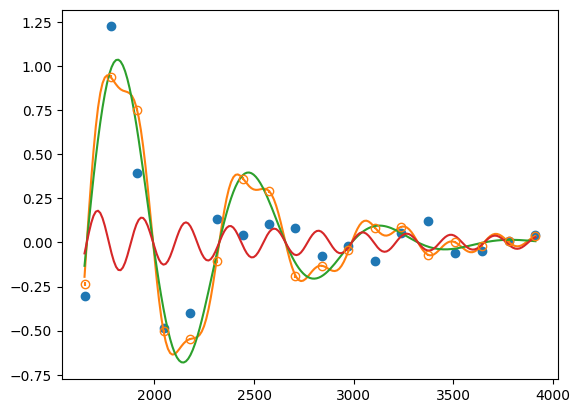

In [149]:
nu_pred = jnp.linspace(nu.min(), nu.max(), 201)
dnu_pred = model.glitch(init_params, nu_pred)

plt.plot(nu, nu-nu_init+dnu_init, "o")
plt.errorbar(nu, dnu_init, yerr=nu_sd, fmt="o", markerfacecolor="none")
plt.plot(nu_pred, dnu_pred, c="C1")

plt.plot(nu_pred, model.helium_glitch(init_params, nu_pred))
plt.plot(nu_pred, model.bcz_glitch(init_params, nu_pred))

In [150]:
leaves, treedef = tree_util.tree_flatten(init_params)
ndim = len(leaves)

periodic_params = {k: v.periodic for k, v in model.prior.items()}
reflective_params = {k: v.reflective for k, v in model.prior.items()}
periodic, = np.where(tree_util.tree_leaves(periodic_params))
reflective, = np.where(tree_util.tree_leaves(reflective_params))

if periodic.size == 0:
    periodic = None
if reflective.size == 0:
    reflective = None

In [151]:
def log_likelihood_wrapper(x):
    params = tree_util.tree_unflatten(treedef, x)
    return model.log_likelihood(params)

def prior_transform_wrapper(u):
    params = tree_util.tree_unflatten(treedef, u)
    return tree_util.tree_leaves(model.prior_transform(params))

# def gradient_wrapper(u):
#     uparams = tree_util.tree_unflatten(treedef, u)
#     return np.array(tree_util.tree_leaves(gradient(uparams)))

In [170]:
rstate = np.random.default_rng(0)
sampler = dynesty.NestedSampler(log_likelihood_wrapper, prior_transform_wrapper,
                                ndim=ndim, nlive=200, rstate=rstate,
                                periodic=periodic, reflective=reflective)
# sampler = dynesty.DynamicNestedSampler(log_likelihood_wrapper, prior_transform_wrapper,
#                                 sample="auto", ndim=ndim, nlive=200, rstate=rstate,
#                                 periodic=periodic, reflective=reflective)
sampler.run_nested()

6224it [00:50, 123.59it/s, +200 | bound: 187 | nc: 1 | ncall: 172398 | eff(%):  3.731 | loglstar:   -inf < 13.560 <    inf | logz: -15.970 +/-  0.344 | dlogz:  0.001 >  0.209]


In [171]:
res = sampler.results

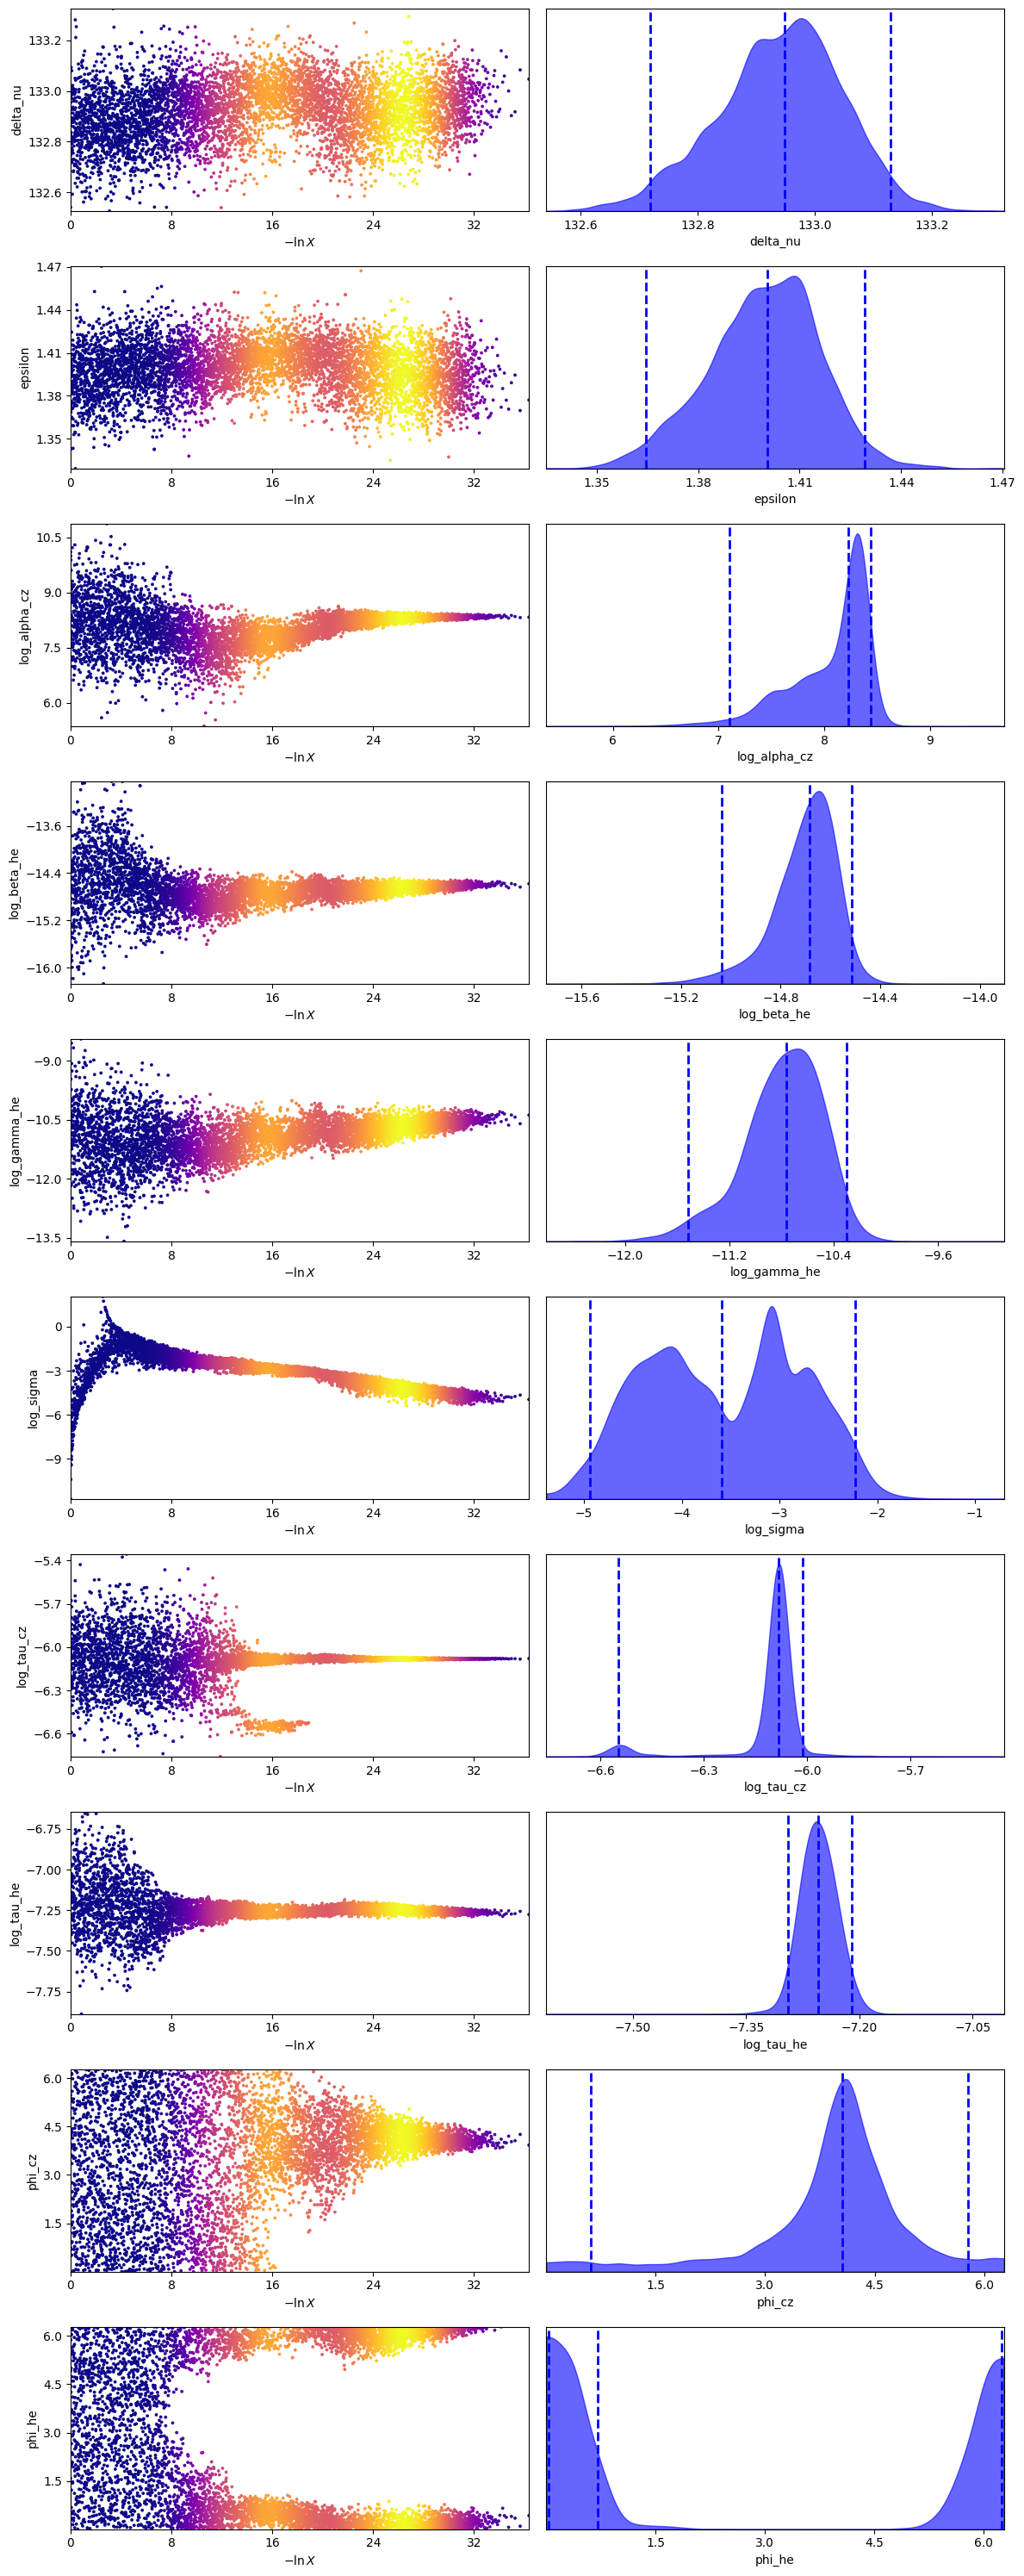

In [172]:
labels = tree_util.tree_leaves({k: k for k in init_params.keys()})
# truths = tree_util.tree_leaves(true_params)
fig, axes = dyplot.traceplot(res, labels=labels)  #, fig=plt.subplots(3, 2, figsize=(16, 12)))
fig.tight_layout()

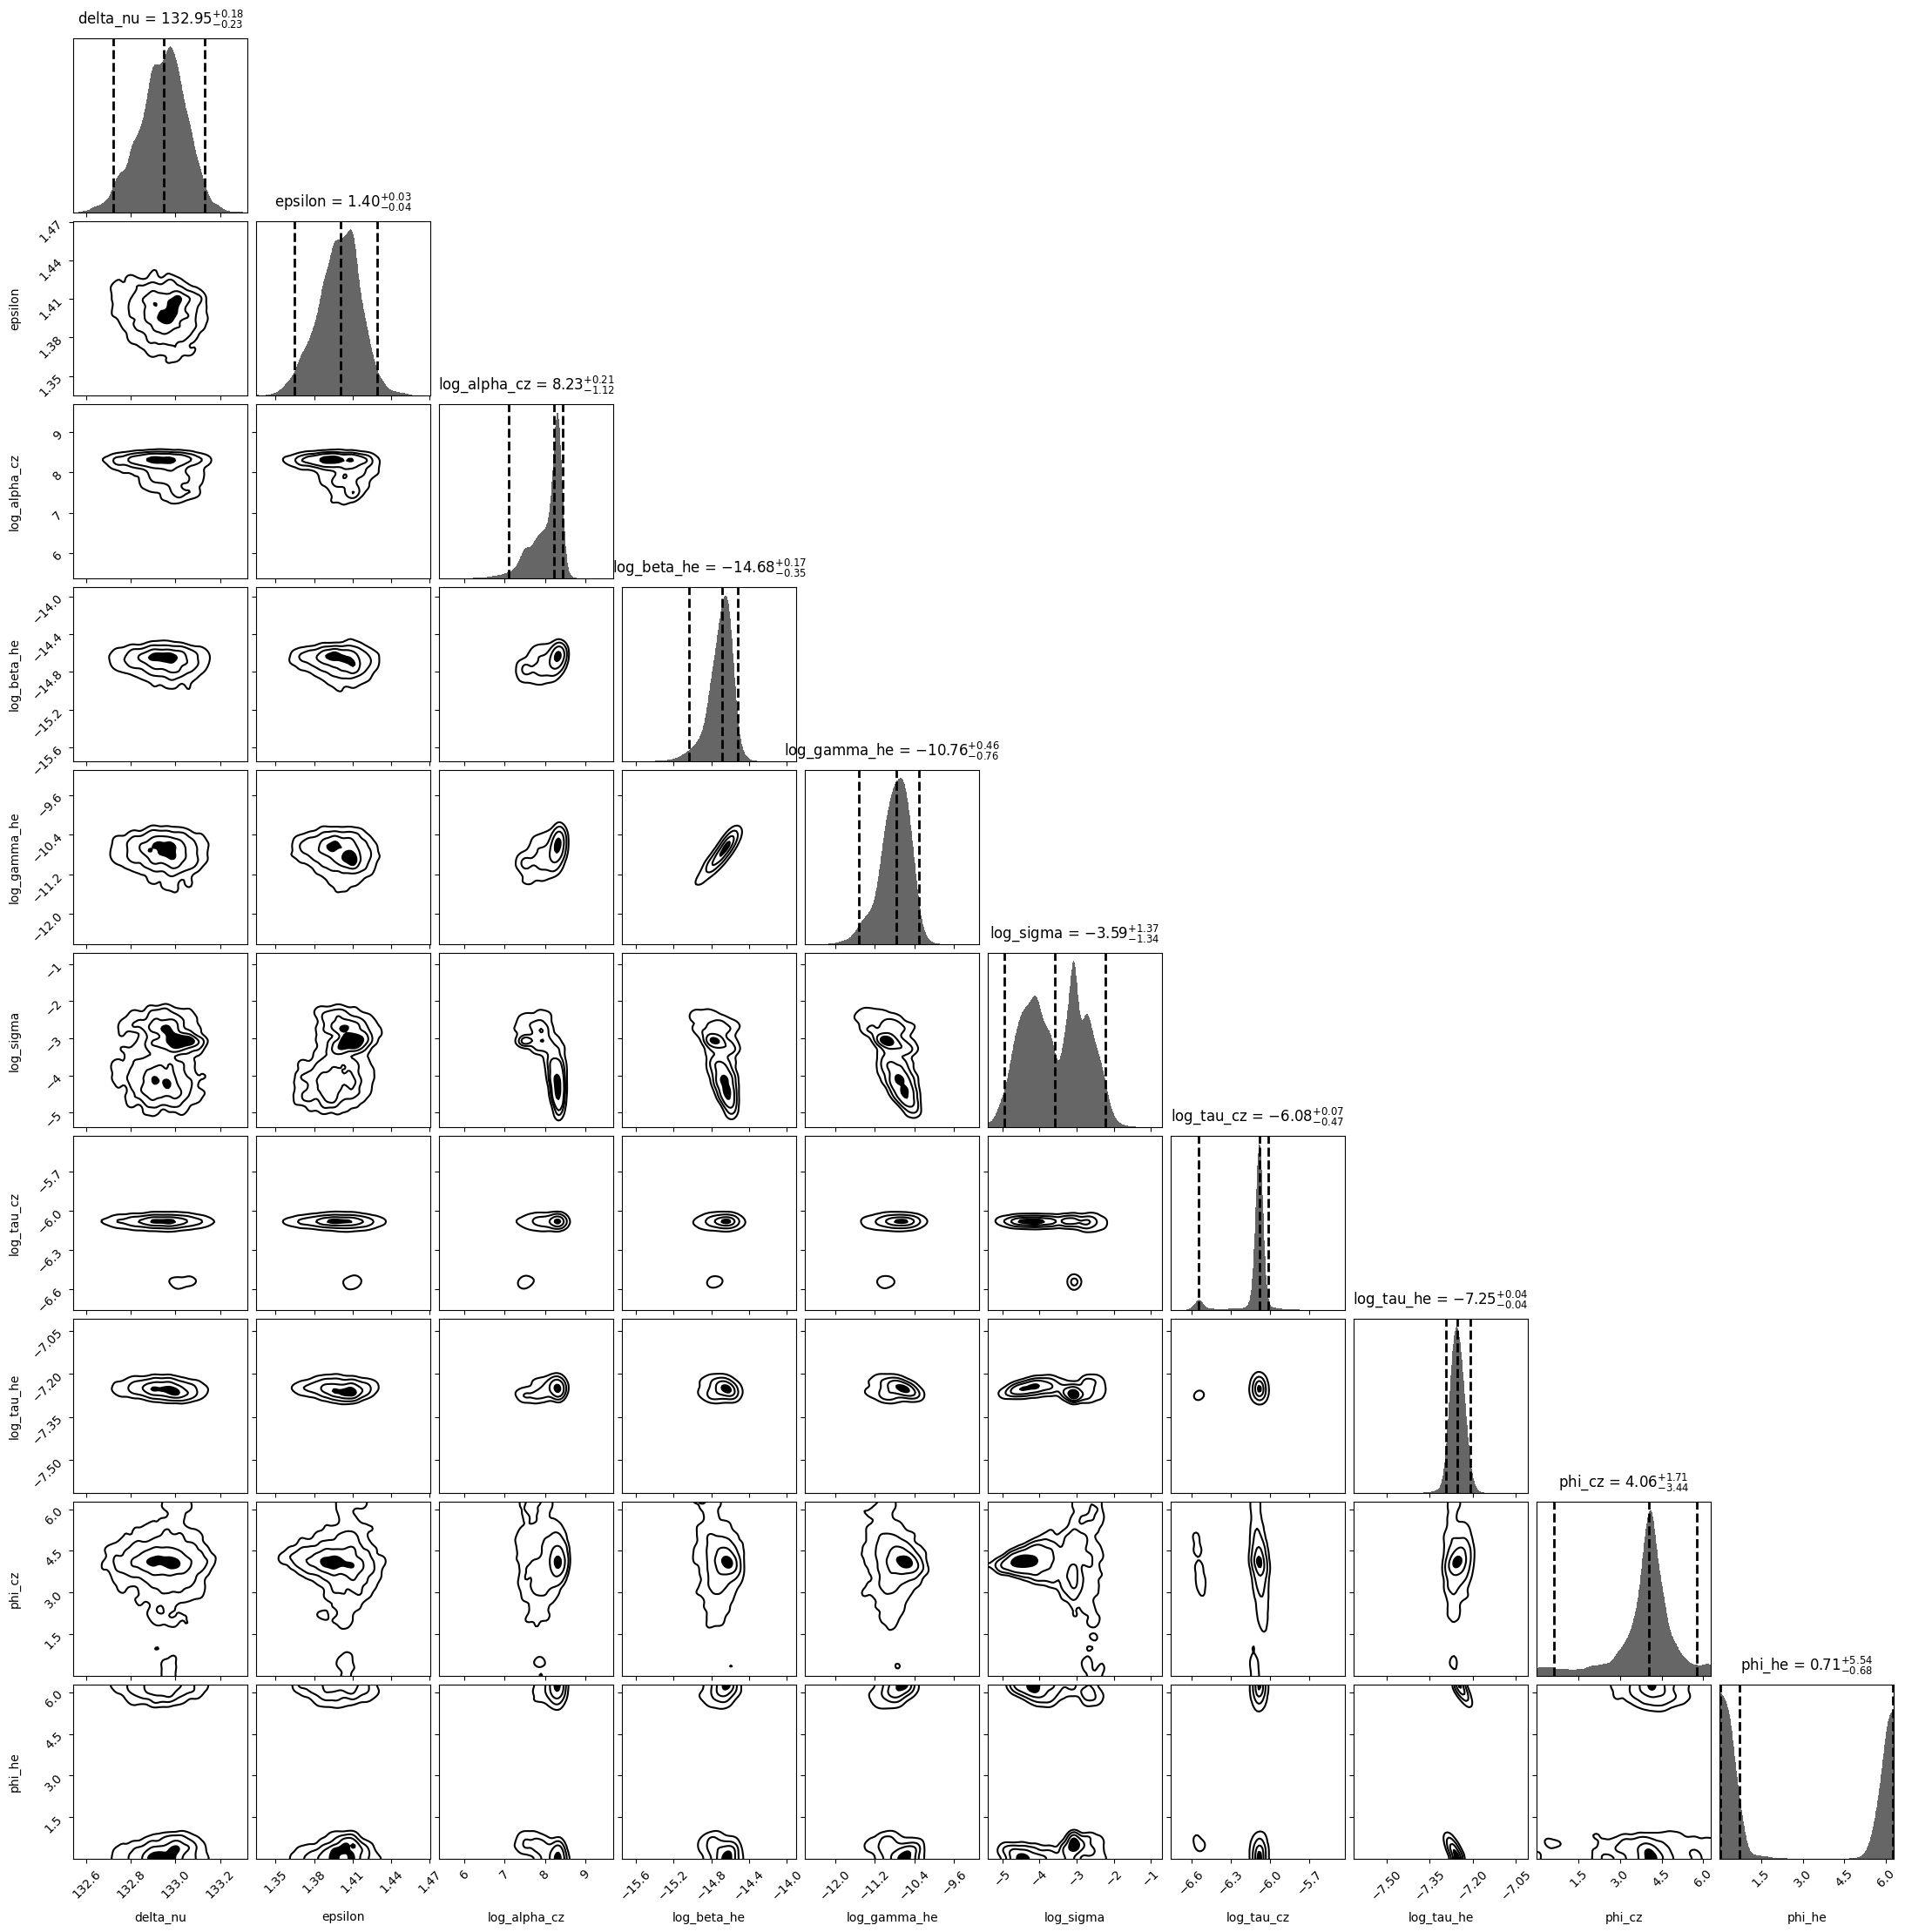

In [173]:
fig, axes = dyplot.cornerplot(res, show_titles=True, title_kwargs={'y': 1.04}, labels=labels)

In [174]:
samples_flat, weights = res.samples, res.importance_weights()
samples_equal = dynesty.utils.resample_equal(samples_flat, weights)
samples = tree_util.tree_unflatten(treedef, list(samples_equal.T))

In [175]:
np.exp(samples["log_tau_he"]).mean()

0.0007074665755300351

In [176]:
np.median(np.exp(samples["log_tau_cz"]))

0.0022843201396869745

In [177]:
dnu = jax.vmap(model.glitch, in_axes=(0, None))(samples, nu_pred)
dnu_med = np.median(dnu, axis=0)
dnu_lower, dnu_upper = np.quantile(dnu, [.16, .84], axis=0)

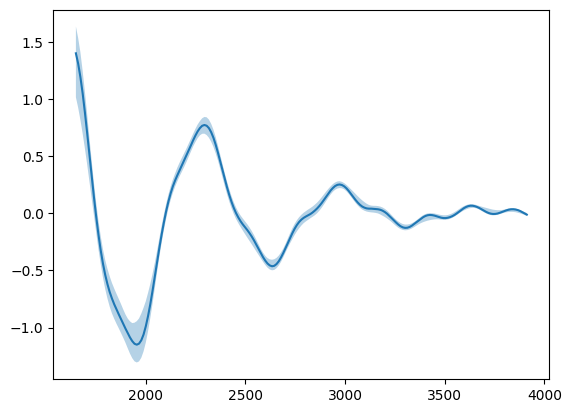

In [178]:
plt.plot(nu_pred, dnu_med)
plt.fill_between(nu_pred, dnu_lower, dnu_upper, alpha=0.33)

(-2.0, 2.0)

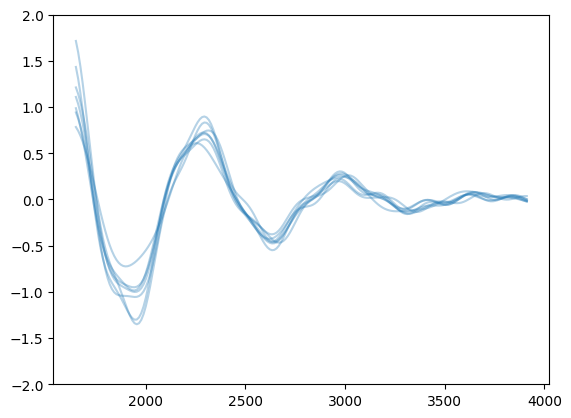

In [179]:
thin = 1000
y = dnu[::thin]
x = np.broadcast_to(nu_pred, y.shape)
plt.plot(x.T, y.T, color="C0", alpha=0.33);
plt.ylim(-2, 2)

In [180]:
med = jax.tree_map(np.median, samples)
low = jax.tree_map(lambda x: np.quantile(x, .16), samples)
upp = jax.tree_map(lambda x: np.quantile(x, .84), samples)

In [181]:
def to_sec(log_tau):
    return 1e6*np.exp(log_tau)

Text(0, 0.5, 'density gradient')

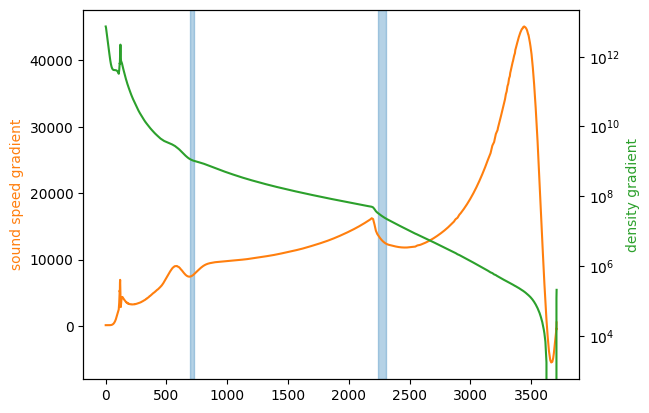

In [182]:
fig, ax = plt.subplots()


for g in ["he", "cz"]:
    # ax.axvline(to_sec(med[f"log_tau_{g}"]), color="C0")
    ax.axvspan(to_sec(low[f"log_tau_{g}"]), to_sec(upp[f"log_tau_{g}"]), 
               color="C0", alpha=0.33)

ax.plot(data.tau, differentiate(data.cs, data.tau), color="C1")
ax.set_ylabel("sound speed gradient", color="C1")

ax = ax.twinx()

ax.plot(data.tau, differentiate(data.cs, data.rho), color="C2")
ax.set_yscale("log")
ax.set_ylabel("density gradient", color="C2")